In [1]:
import os

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_pickle("../../data/dair-ai-emotions/merged_training.pkl")
df

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [3]:
surprise_count = len(df.loc[df['emotions'] == 'surprise'])

joy = df.loc[df['emotions'] == 'joy'].iloc[:surprise_count]
sadness = df.loc[df['emotions'] == 'sadness'].iloc[:surprise_count]
anger = df.loc[df['emotions'] == 'anger'].iloc[:surprise_count]
fear = df.loc[df['emotions'] == 'fear'].iloc[:surprise_count]
love = df.loc[df['emotions'] == 'love'].iloc[:surprise_count]
surprise = df.loc[df['emotions'] == 'surprise']

In [4]:
frames = [joy, sadness, anger, fear, love, surprise]
equal_dataset = pd.concat(frames)

np.random.shuffle(equal_dataset.values)
equal_dataset

,text,emotions
140764,i have ever posted on grief boards or where ev...,anger
10714,im not the only one feeling curious as i stumb...,surprise
35177,i really feel like the funny turn was probably...,surprise
122177,i looked back through all my past experiences ...,surprise
98659,i share but instead question the soundness of ...,sadness
...,...,...
10560,i could go through my pictures and do this wit...,love
5282,i read it in minutes and not feel so curious a...,surprise
6187,i feel hated a href http predmore,anger
6813,i want to trust you and feel loved by you but ...,love


In [5]:
# It is only fine-tuning, thus 400k data samples is a complete overkill. It can be reduced to 40k.
df = equal_dataset.iloc[:40000]

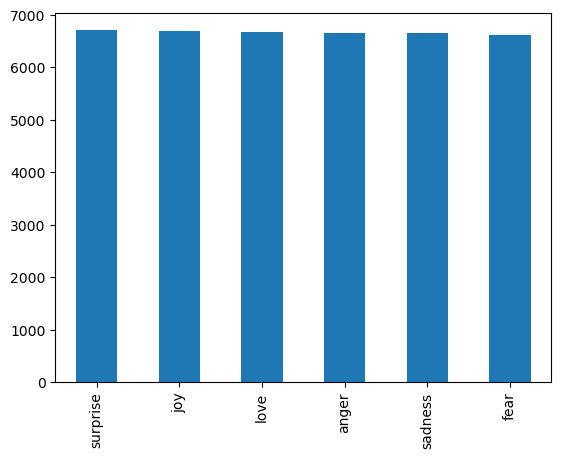

In [6]:
data = df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [7]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [8]:
df = df.replace({"emotions": ordered_class_labels})

In [9]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Dataset({
    features: ['text', 'emotions'],
    num_rows: 40000
})

In [10]:
from transformers import AutoTokenizer

MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

tokenizer.padding_side = "left"

In [11]:
def tokenize_function(examples):
    examples = [ex + EOS_TOKEN for ex in examples['text']]

    output = tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

In [12]:
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [13]:
# Train set: 80%, Validation set: 10%, Test set: 10%
split_train_val_and_test_dataset = tokenized_dataset.train_test_split(train_size=0.8)
split_val_test_dataset = split_train_val_and_test_dataset["test"].train_test_split(test_size=0.5)

tokenized_train_dataset = split_train_val_and_test_dataset["train"]
tokenized_val_dataset = split_val_test_dataset["train"]
tokenized_test_dataset = split_val_test_dataset["test"]

In [14]:
from transformers import DataCollatorWithPadding

batch_size = 16


def convert_to_tf_dataset(hf_dataset, collator, batch_size=batch_size, shuffle=False):
    return hf_dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["emotions"],
        collate_fn=collator,
        shuffle=shuffle,
        batch_size=batch_size,
    )


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = convert_to_tf_dataset(hf_dataset=tokenized_train_dataset, collator=data_collator)
tf_val_dataset = convert_to_tf_dataset(hf_dataset=tokenized_val_dataset, collator=data_collator)
tf_test_dataset = convert_to_tf_dataset(hf_dataset=tokenized_test_dataset, collator=data_collator)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [15]:
import Constants

# Callbacks
training_number = 1
model_name = "emotions_eng_gpt2"
training_folder = f"training_{training_number}"
checkpoint_filename = "cp-{epoch:04d}.ckpt"
training_path = os.path.join(Constants.TRAINING_CHECKPOINTS_PATH, model_name, training_folder)
checkpoint_path = os.path.join(training_path, checkpoint_filename)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)

In [16]:
checkpoint_path

'../training_checkpoints\\emotions_eng_gpt2\\training_1\\cp-{epoch:04d}.ckpt'

In [17]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [18]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id, use_cache=False, num_labels=6)

All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model.summary()

Model: "tfgp_t2for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
score (Dense)                multiple                  4608      
_________________________________________________________________
transformer (TFGPT2MainLayer multiple                  124439808 
Total params: 124,444,416
Trainable params: 124,444,416
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [21]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs,
                    callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
2000/2000 [==============================] - 256s 121ms/step - loss: 0.7270 - accuracy: 0.7108 - val_loss: 0.2735 - val_accuracy: 0.9020

Epoch 00001: saving model to ../training_checkpoints\emotions_eng_gpt2\training_1\cp-0001.ckpt
Epoch 2/10
2000/2000 [==============================] - 240s 120ms/step - loss: 0.2492 - accuracy: 0.9020 - val_loss: 0.2451 - val_accuracy: 0.9053

Epoch 00002: saving model to ../training_checkpoints\emotions_eng_gpt2\training_1\cp-0002.ckpt
Epoch 3/10
2000/2000 [==============================] - 240s 120ms/step - loss: 0.2196 - accuracy: 0.9114 - val_loss: 0.2403 - val_accuracy: 0.9032

Epoch 00003: saving model to ../training_checkpoints\emotions_eng_gpt2\training_1\cp-0003.ckpt
Epoch 4/10
2000/2000 [==============================] - 240s 120ms/step - loss: 0.2012 - accuracy: 0.9168 - val_loss: 0.2234 - val_accuracy: 0.9080

Epoch 00004: saving model to ../training_checkpoints\emotions_eng_gpt2\training_1\cp-0004.ckpt
Epoch 5/10
2000/2000 [==

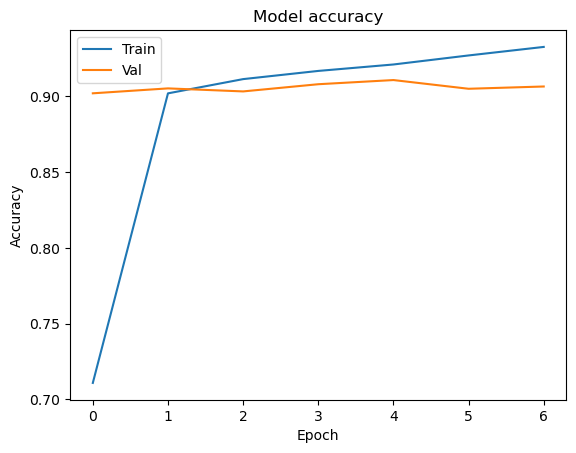

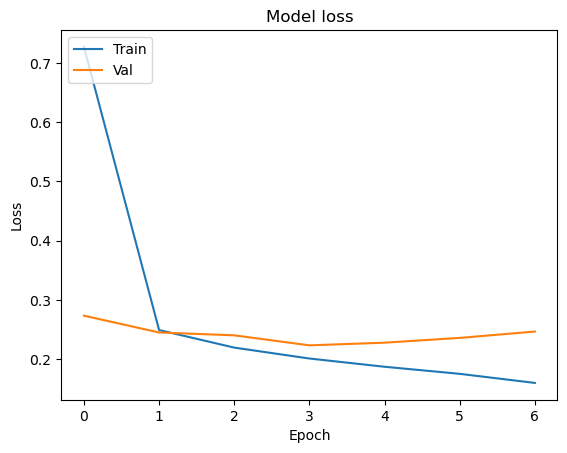

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../../documentation/models/{model_name}/figures/{training_folder}_accuracy.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../../documentation/models/{model_name}/figures/{training_folder}_loss.png")
plt.show()

In [23]:
import shutil

best_model_checkpoint_index = np.argmin(history.history["val_accuracy"]) + 1
best_model_weights_path = os.path.join(training_path, checkpoint_filename.format(epoch=best_model_checkpoint_index))
best_model = model
best_model.load_weights(best_model_weights_path)

shutil.rmtree(training_path)

In [24]:
saved_model_name = f"{model_name}_{training_number}"

# Save to Saved Model format
best_model.save(os.path.join(Constants.SAVED_MODEL_LOCATION, saved_model_name, Constants.DEFAULT_MODEL_VERSION))

INFO:tensorflow:Assets written to: ../trained_models\emotions_eng_gpt2_1\1\assets


INFO:tensorflow:Assets written to: ../trained_models\emotions_eng_gpt2_1\1\assets


In [25]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=32)

250/250 [==============================] - 10s 38ms/step - loss: 0.2448 - accuracy: 0.9040


[0.24482136964797974, 0.9039999842643738]

In [26]:
# Getting predictions
prediction_logits = best_model.predict(tf_test_dataset)['logits']
probabilities = tf.nn.softmax(prediction_logits)
class_preds = np.argmax(probabilities, axis=1)

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(tokenized_test_dataset['emotions'], class_preds, average='macro')
recall = recall_score(tokenized_test_dataset['emotions'], class_preds, average='macro')
f1 = f1_score(tokenized_test_dataset['emotions'], class_preds, average='macro')

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.9084654813075566
Recall score:  0.9046037668113659
F1 score:  0.9037133595597272


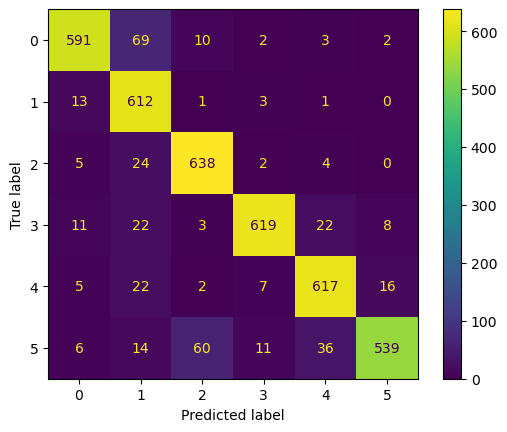

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

result = confusion_matrix(tokenized_test_dataset['emotions'], class_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()
plt.savefig(f"../../documentation/models/{model_name}/figures/{training_folder}_confmatrix.png")
plt.show()